# Mother Machine Diffusion Model Version 3.2
#### To be uploaded in support of Wedd et al 2024
#### Aaron Smith 2024

## Preamble

#### Discretised Diffusion Equation
Older models were based on iterating over the equation:  

$$\Delta V =  \biggl( \frac{D}{(\Delta x)^2}(V_{x+1,y,z}+V_{x-1,y,z}+V_{x,y+1,z}+V_{x,y-1,z}+V_{x,y,z+1}+V_{x,y,z-1} - 6V_{x,y,z})-a(x,y,z)V_{x,y,z} \biggr) \Delta t$$

#### Random Walk
This model seeks to solve the same problem faster by tracking individual phage as random walkers in a 3D lattice rather than by evaluating a continuous concentration at all points.

#### Notes
Note further that **"x" represents the vertical direction (DOWN), and "y" the horizontal direction (RIGHT).** This choice is to keep the cross section coordinates (x down, y right) equivalent to array indices (row x of X, column y of Y).

#### Equations
Probability distribution $V$ evolves according to:
$$\frac{\partial V}{\partial t} = D\frac{\partial^2 V}{\partial x^2}$$

For Diffusivity $D$ related to Random-Walk by:
$$D = \frac{(\Delta x)^2}{2 \Delta t}$$

Through Relating Probability Distributions:
$$P(x,t)
= \sqrt{\frac{\Delta t}{2\pi t}} \exp\biggl(- \frac{\Delta tx^2}{2t(\Delta x)^2}\biggr)
= \sqrt{\frac{(\Delta x)^2}{4\pi Dt}} e^{-x^2/4Dt}
$$

### How To Use This Code
All parameters are set using the block directly under "Initialisation". Users looking to reproduce the results presented in *Wedd et al 2024* should not need to make any edits outside of this block.

### Operation
At a high level, the program operates as follows:
- We define a cross-section, with each cell being either liquid, hard-wall, or *E coli*.
- We simulate a number of trenches in parallel by making phages non-interacting with each other (essentially assuming a low-concentration limit, of order 1 per trench).
- At every timestep, each unbound virion tries to take a step in x, y, and z, doing these one at a time, and failing if it tries to step into a wall. If it tries to step into an *E coli* there is a probability $A$ that it will adsorb and stick there.
- Virions that step to negative z are assumed to flow away after returning to the feeding lane, and are removed from the sim.

## Code

### Import Modules and Draw Trench Cross-Sections

In [1]:
## Import Statements ##
import numpy as np
import scipy as sp
import pandas as pd
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import itertools as itl
from alive_progress import alive_bar
import numba
from numba import jit

## Perceptually Uniform Colourmaps ##
viridis = mpl.cm.viridis
magma = mpl.cm.magma

In [2]:
## Cross-Section Library ##
#### NOTE - ALL MEASUREMENTS ARE NOW IN NANOMETERS ####



# Narrow Empty Channel for Testing
def XS0(dx):
    h = 400    # XSec height (x) in nm
    w = 400    # XSec width (y) in nm
    H = int(round(h/dx))    # XSec height (x) in pxl
    W = int(round(w/dx))    # XSec width (y) in pxl
    XSec = np.zeros([H,W])

    for (i,j) in itl.product(range(0,H),range(0,W)):
        if i == 0 or i == H-1: XSec[i,j] = 1    #Wall
        if j == 0 or j == W-1: XSec[i,j] = 1    #Wall
        
    return(XSec)



# Cross Section Nature Narrow
def XSNn(dx):
    h = 1400    # XSec height (x) in nm
    w = 1400    # XSec width (y) in nm
    H = int(round(h/dx))    # XSec height (x) in pxl
    W = int(round(w/dx))    # XSec width (y) in pxl
    XSec = np.zeros([H,W])

    for (i,j) in itl.product(range(0,H),range(0,W)):
        if i == 0 or i == H-1: XSec[i,j] = 1    #Wall
        if j == 0 or j == W-1: XSec[i,j] = 1    #Wall
        if ((i+0.5)*dx-(900-dx))**2 + ((j+0.5)*dx-700)**2 <= 500**2: XSec[i,j] = 2    #Cell, radius 500nm; centre (900nm - dx) down, 700nm right.
    
    print("Chosen Scale: {} nm per pixel.".format(dx))
    print("Cross-Section includes dimensions: 1400 (Walls), 900nm, 700nm, 500nm (Cell).")
    print("These have been scaled to: {}, {}, {}, {} pixels".format(1400/dx, 900/dx, 700/dx, 500/dx))
    print("Note that non-integer scaling, espcially in trench width and height, may skew the geometry.")
    
    return(XSec)



# Cross Section Nature Wide
def XSNw(dx):
    h = 1400    # XSec height (x) in nm
    w = 7000    # XSec width (y) in nm
    H = int(round(h/dx))    # XSec height (x) in pxl
    W = int(round(w/dx))    # XSec width (y) in pxl
    XSec = np.zeros([H,W])

    for (i,j) in itl.product(range(0,H),range(0,W)):
        if i == 0 or i == H-1: XSec[i,j] = 1    #Wall
        if j == 0 or j == W-1: XSec[i,j] = 1    #Wall
        if 0 < (i+0.5)*dx < 1000 and 0 < (j+0.5)*dx < 2800: XSec[i,j] = 1    #Block
        if 0 < (i+0.5)*dx < 1000 and 4200 < (j+0.5)*dx < 7000: XSec[i,j] = 1    #Block
        if ((i+0.5)*dx-(900-dx))**2 + ((j+0.5)*dx-3500)**2 <= 500**2: XSec[i,j] = 2    #Cell, radius 500nm; centre (900nm - dx) down, 3500nm right.
    
    print("Chosen Scale: {} nm per pixel.".format(dx))
    print("Cross-Section includes dimensions: 7000nm, 1400nm (Walls), 3500nm, 900nm, 500nm (Cell), 4200nm, 2800nm, 1000nm (Blocks).")
    print("These have been scaled to: {}, {}, {}, {}, {}, {}, {}, {} pixels".format(7000/dx, 1400/dx, 3500/dx, 900/dx, 500/dx, 4200/dx, 2800/dx, 1000/dx))
    print("Note that non-integer scaling, espcially in trench width and height, may skew the geometry.")
    
    return(XSec)



## Cross Section Dictionary ##
XSecs = {"XS0" : XS0,
         "XSNn": XSNn,
         "XSNw": XSNw}

### Define Objects and Functions

In [3]:
## Define the Random Step Function using Numba ##

@jit(nopython = True)
def Random_Step_Optimised(coords, cross_section, adsorb_prob, free, z_max, can_escape):

    for i in range(len(coords)):        # For each of x, y, z:

        coinflip = (-1)**(np.random.randint(0, 2))   # Either +1 or -1, at random.
        coords[i] += coinflip                   # Attempt to take a step

        if cross_section[coords[0], coords[1]] == 1:   # If we hit a wall, bounce off
            coords[i] -= coinflip

        elif cross_section[coords[0], coords[1]] == 2:    # If we hit a cell, bounce or adsorb  
            if np.random.rand() < adsorb_prob:
                free = "bound"   # Virion wil finish this movement step, and then halt
            coords[i] -= coinflip
                    
    if coords[2] == z_max:    # If we hit the far end of the trench, bounce off
        coords[2] -= coinflip
#       print("Bounced off the end at {} during step {}".format(self.coords, len(self.path)))
                
    if coords[2] < 0 and can_escape :    # If we hit the near end of the trench, fall out
        free = "escaped"
#       print("Escaped at {} during step {}".format(self.coords, len(self.path)))
            
#   if self.free == "bound":
#       print("Adsorbed at {} during step {}".format(self.coords, len(self.path)))
                
    return(coords, cross_section, adsorb_prob, free)


In [4]:
## Define a Class for the Virion object ##

class Virion:
    
    def __init__(self, start_coordinates, adsorb_prob, can_escape = True):
        self.coords = np.asarray(start_coordinates)
        self.path = [copy.copy(self.coords)]    # List of all previously occupied positions
        self.free = "unbound"    # Is phage currently unbound, bound, or escaped?
        self.adsorb_prob = adsorb_prob
        self.lag_table = []
        self.can_escape = can_escape
        
    def __str__(self):
        return("Virion Object at Coordinates: {}.".format(self.coords))
        
        
    def Random_Step(self, cross_section, z_max):
        self.coords, self.cross_section, self.adsorb_prob, self.free = Random_Step_Optimised(self.coords, cross_section, self.adsorb_prob, self.free, z_max, self.can_escape)
        self.path.append(copy.copy(self.coords)) # Record New Position
    

In [5]:
## Plotting Functions ##

def Trace(x, y, c, maxima, Nt = None, cmap = viridis):
    
    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    fig, axs = plt.subplots()
    axs.set_xlim(0, maxima[0])
    axs.set_ylim(0, maxima[1])
    axs.xaxis.set_ticks_position('top')
    axs.xaxis.set_label_position('top')
    axs.invert_yaxis()

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(0, Nt)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    # Set the values used for colormapping
    lc.set_array(c)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    cbar = fig.colorbar(line, ax=axs)
    cbar.outline.set_visible(False)
    cbar.ax.set_ylabel("Timestep", rotation=-90, va="bottom")
    
    return()




def Plot_Traces(phage, xsec, zmax, Nt, how_many = 1, cmap = viridis):
    X = []
    Y = []
    Z = []

    for entry in phage.path:
        X.append(entry[0])
        Y.append(entry[1])
        Z.append(entry[2])

    C = np.linspace(0, len(X), len(X))
    
    if how_many in [2, 3]:
        Trace(Y, X, C, (len(xsec[0])-1, len(xsec)-1), Nt, cmap)
        plt.xlabel("Y Direction / Voxels")
        plt.ylabel("X Direction / Voxels")
        plt.title("Cross-Section View")
    
    if how_many in [3]:
        Trace(Z, X, C, (zmax, len(xsec)-1), Nt, cmap)
        plt.xlabel("Z Direction / Voxels")
        plt.ylabel("X Direction / Voxels")
        plt.title("Side View")
    
    if how_many in [1, 2, 3]:
        Trace(Y, Z, C, (len(xsec[0])-1, zmax), Nt, cmap)
        plt.xlabel("Y Direction / Voxels")
        plt.ylabel("Z Direction / Voxels")
        plt.title("Top View")
    return()
    

### Initialisation

In [6]:
## Simulation Parameters ##

# Free #
dx = 50    # Step size in nm
D = 4    # Diffusivity in um^2 per s
V_rad = 25    # Virion radius (nm), assumed spherical
aB0 = 10    # Adsorbtion Rate in bulk, per minute (ml per min); either float, or list of floats.
Z_um = 70    # Trench length in um
XS_str = "XSNw"    # Selected Cross Section, either XS0, XSNn, XSNw as string
Can_Escape = True    # Whether to allow virions which enter the feeding lane (z < 0) to escape the simulation.
N_parallel = 1*10**5    # Number of phage paths to simulate. Phages are all run in series / non-interacting.
T = 20*60    # Simulation Timeout in seconds (of simulated time).
np.random.seed(1)

# Array Jobs #
if type(aB0) == list:
    ArrayID = int(sys.argv[1])
    aB0 = aB0[ArrayID]

# Calculated #
dt = (dx/1000)**2 / (2*D)
A = 2 * aB0 * dt / 60    # Adsorption Probability on attempting to move into cell.
V_vox = int(round(V_rad / dx))
Z_vox = int((Z_um*1000 / dx) + 1)    # Trench length in voxels. +1 added for hard wall at the end
C_vox = 2000 / dx    # Length of cell in voxels
XS = XSecs[XS_str](dx)    # XS calculated by calling the appropriate function, with dx_nm as the argument
Height = len(XS)
Width = len(XS[0])
Nt = int(T/dt)

# Print Calculated #
print()
print("dt: ", dt)
print("A: ", A)
print("V_vox: ", V_vox)
print("Z_vox: ", Z_vox)
print("Height: ", Height)
print("Width: ", Width)
print("Nt: ", Nt)

if A >= 1:
    raise Exception("Error: Adsorbtion Probability Exceeds 1")

Chosen Scale: 50 nm per pixel.
Cross-Section includes dimensions: 7000nm, 1400nm (Walls), 3500nm, 900nm, 500nm (Cell), 4200nm, 2800nm, 1000nm (Blocks).
These have been scaled to: 140.0, 28.0, 70.0, 18.0, 10.0, 84.0, 56.0, 20.0 pixels
Note that non-integer scaling, espcially in trench width and height, may skew the geometry.

dt:  0.00031250000000000006
A:  0.00010416666666666669
V_vox:  0
Z_vox:  1401
Height:  28
Width:  140
Nt:  3839999


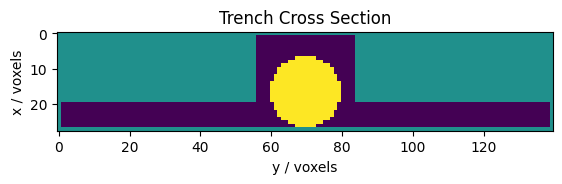

<Figure size 640x480 with 0 Axes>

In [7]:
## Display Chosen Cross Section ##
plt.imshow(XS, cmap = viridis, vmin = 0, vmax = 2, interpolation = "none")
plt.xlabel("y / voxels")
plt.ylabel("x / voxels")
plt.title("Trench Cross Section")
plt.show()
plt.clf()

Calculating Exclusion Zones


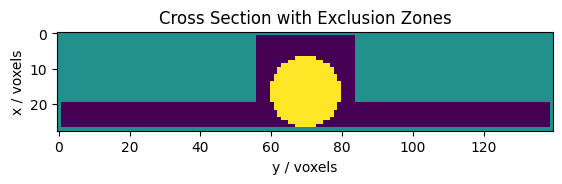

<Figure size 640x480 with 0 Axes>

In [8]:
## Create "Shadows ##
# Pixels may be smaller than the virion. Compensate this by reducing the virion to a point, and expanding the cell and walls by virion radius.

XS_Shadow = copy.copy(XS)

# Shadows #
print("Calculating Exclusion Zones")
for (i, j, di, dj) in itl.product(range(Height), range(Width), range(-V_vox, V_vox+1), range(-V_vox, V_vox+1)):

    # Cell Shadows #
    if XS[i,j] == 2:
        if (di)**2 + (dj)**2 <= (V_vox)**2 and (i + di) in range(Height) and (j + dj) in range(Width):
            XS_Shadow[i + di, j + dj] = 2

    # Wall Shadows #
    elif XS[i,j] == 1:
        if (di)**2 + (dj)**2 <= (V_vox)**2 and (i + di) in range(Height) and (j + dj) in range(Width):
            XS_Shadow[i + di, j + dj] = 1

            

            
## Display Shadow Cross Section ##
# Create a special cross section (for visual use only) which distinguishes from "truly" the cell, and the cell's exclusion zone.
XS_Display = copy.copy(XS)

for (i,j) in itl.product(range(Height), range(Width)):
    if XS_Shadow[i,j] != XS[i,j]:
        if XS_Shadow[i,j] == 1:
            XS_Display[i,j] = 0.5
        elif XS_Shadow[i,j] == 2:
            XS_Display[i,j] = 1.7

plt.imshow(XS_Display, cmap = viridis, vmin = 0, vmax = 2, interpolation = "none")
plt.xlabel("y / voxels")
plt.ylabel("x / voxels")
plt.title("Cross Section with Exclusion Zones")
plt.show()
plt.clf()

# Finally, use the shadow cross section as the one we actually want to work with #
XS = XS_Shadow

In [9]:
## Create the set of Virions ##

Virion_Set = []

# Create Random (Liquid) Start Coordinates #
for i in range(N_parallel):
    
    start_coords = np.array([0,0,0])
    
    while XS[start_coords[0], start_coords[1]] != 0:
        start_coords[0] = np.random.randint(0, Height)
        start_coords[1] = np.random.randint(0, Width)
    
    Virion_Set.append(Virion(start_coords, A, Can_Escape))
   

### Run the Simulation

In [10]:
print("Running Simulation")
with alive_bar(N_parallel, force_tty = True) as bar:  # Load a progress bar for N_parallel

# Run all ticks for one virion, then all ticks for the next, etc. #
    for i in range(len(Virion_Set)):
        Virion = Virion_Set[i]
#        print("Virion {}".format(i))

        # In theory, run for the full allowed time, but break early if the virion adsorbs or escapes. #
        for tick in range(Nt):

            Virion.Random_Step(XS, Z_vox)

            if Virion.free != "unbound":
                break
            
#    if Virion.free == "unbound":
#        print("Remains unbound at {} after {} steps".format(Virion.coords, len(Virion.path)-1))

        bar()


Running Simulation
|████████████████████████████████████████| 100000/100000 [100%] in 8:55.6 (186.5 ▂▂▄ 194/100000 [0%] in 2s (~15:30, 10 ▄▆█ 194/100000 [0%] in 2s (~17:34, 91 ▆▄▂ 194/100000 [0%] in 3s (~20:53, 77 ▅▃▁ 1775/100000 [2%] in 8s (~7:13, 22 ▅▃▁ 2764/100000 [3%] in 10s (~5:58, 2 ▅▃▁ 3913/100000 [4%] in 17s (~7:08, 2 ▁▃▅ 7435/100000 [7%] in 32s (~6:37, 2 ▄▆█ 10705/100000 [11%] in 37s (~5:09, ▄▆█ 10874/100000 [11%] in 39s (~5:15, ▇▅▃ 12046/100000 [12%] in 42s (~5:09, ▄▂▂ 12371/100000 [12%] in 43s (~5:10, ▆█▆ 13251/100000 [13%] in 49s (~5:18, ▄▆█ 15534/100000 [16%] in 1:01 (~5:29 ▃▅▇ 17067/100000 [17%] in 1:05 (~5:17 ▅▇▇ 17882/100000 [18%] in 1:10 (~5:21 ▇▇▅ 20682/100000 [21%] in 1:33 (~5:54 ▃▅▇ 21230/100000 [21%] in 1:37 (~5:58 ▆█▆ 21763/100000 [22%] in 1:40 (~5:59 ▇▅▃ 23018/100000 [23%] in 1:51 (~6:13 ▂▂▄ 24320/100000 [24%] in 2:00 (~6:13 ▇▅▃ 24612/100000 [25%] in 2:03 (~6:15 ▄▆█ 25931/100000 [26%] in 2:08 (~6:05 █▆▄ 28639/100000 [29%] in 2:17 (~5:41 ▆█▆ 28852/100000 [29%] in 

### Plot Trajectories

In [11]:
skip_this_section = True

if not skip_this_section:
    Longest_Path = max(len(virion.path) for virion in Virion_Set)
    Plotting_Lower_Limit = Longest_Path  # Plot paths at least this long (currently plotting longest only)

    for i in range(len(Virion_Set)):
        Virion = Virion_Set[i]

        if len(Virion.path) >= Plotting_Lower_Limit:
            Plot_Traces(Virion, XS, Z_vox, None, 3)

### Plot Adsorption Histogram

In [12]:
## Headlines: What Happened? ##

No_Adsorbed = 0
No_Escaped = 0
No_Remaining = 0

for virion in Virion_Set:
    if virion.free == "bound":
        No_Adsorbed += 1
    elif virion.free == "escaped":
        No_Escaped += 1
    else:
        No_Remaining += 1
        
print("Total Virions Adsorbed: ", No_Adsorbed)
print("Total Virions Escaped: ", No_Escaped)
print("Total Virions Remaining: ", No_Remaining)

Total Virions Adsorbed:  265
Total Virions Escaped:  99735
Total Virions Remaining:  0


Adsorptions by cell:  [28. 24. 23. 20. 20. 14. 13. 14. 14. 11.  9. 10.  5.  5.  1.  5.  3.  7.
  4.  3.  0.  1.  3.  4.  1.  0.  1.  2.  4.  1.  3.  5.  2.  2.  3.]
Escaped phage:  99735


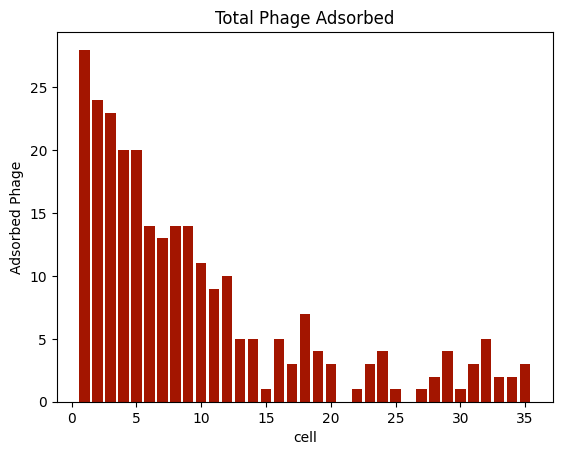

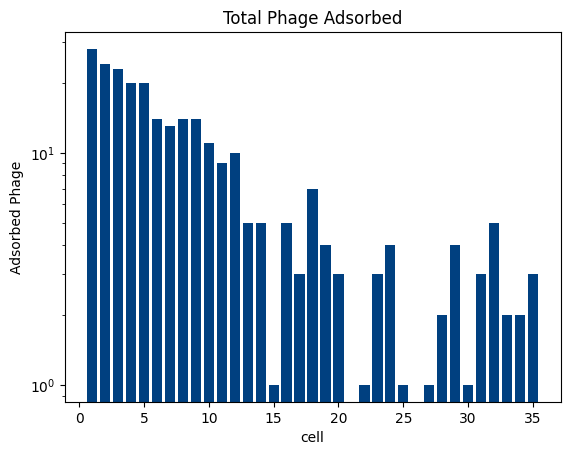

<Figure size 640x480 with 0 Axes>

In [13]:
## Hist: Histogram of Adsorptions by Voxel ##

Hist_X = np.linspace(0, Z_um, Z_vox)
Hist_Y = np.zeros(Z_vox)

for i in range(len(Virion_Set)):
    Virion = Virion_Set[i]
    if Virion.free == "bound":
        Hist_Y[Virion.coords[2]] += 1

#print(Hist_Y)
        
## Cells: Histogram of Adsorptions by Cell ##

N_Cells = int((Z_vox - 1) / C_vox)
Cells_X = np.linspace(1, N_Cells, N_Cells)
Cells_Y = np.zeros(N_Cells)

for i in range(Z_vox-1):
    j = int(i / C_vox)
    Cells_Y[j] += Hist_Y[i]

print("Adsorptions by cell: ", Cells_Y)   
print("Escaped phage: ", No_Escaped)


# Plot Linear Scale #
plt.bar(Cells_X, Cells_Y, log = False, color = "#a31500")
plt.xlabel("cell")
plt.ylabel("Adsorbed Phage")
plt.title("Total Phage Adsorbed")
plt.show()
plt.clf()

# Plot Log Scale #
plt.bar(Cells_X, Cells_Y, log = True, color = "#004080")
plt.xlabel("cell")
plt.ylabel("Adsorbed Phage")
plt.title("Total Phage Adsorbed")
plt.show()
plt.clf()

### Save Data

In [14]:
# ## Concatenate Cells_X and Cells_Y into a single array, then save ##

# Array_to_Save = np.array(list(zip(Cells_X, Cells_Y)))

# np.savetxt("MMRW_3.2. N_{}. aB0_{}. {}. dx_{} esc_{}.csv".format(N_parallel, aB0, XS_str, dx, Can_Escape), Array_to_Save, delimiter=",")

### Check Data Recoverable

In [15]:
# PandasDataFrame = pd.read_csv("MMRW_3.2. N_{}. aB0_{}. {}. dx_{} esc_{}.csv".format(N_parallel, aB0, XS_str, dx, Can_Escape), header = None)
# Array_Recovered = np.array(PandasDataFrame)
# print(Array_Recovered)